# Regression - Housing Price Prediction

In [141]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd 
import lightgbm as lgb 
from sklearn import pipeline
from sklearn import model_selection 
from sklearn import metrics
from sklearn import preprocessing 
from sklearn import compose
from yellowbrick.regressor import *


train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Grab Column Dtypes

In [142]:
numeric_ = train.select_dtypes(['int','float']).columns
object_ = train.select_dtypes(['O']).columns

train['LogPrice'] = train['SalePrice'].apply(np.log1p)

# EDA

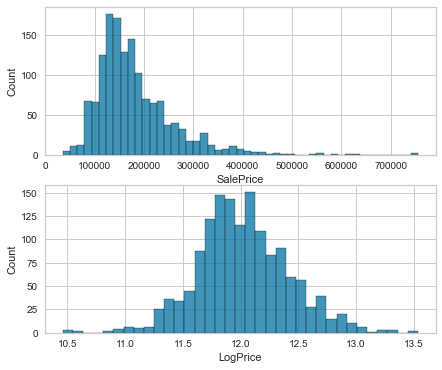

In [143]:
fig,axs=plt.subplots(2,1, figsize=(7,6))
sns.histplot(train['SalePrice'],ax=axs[0])
sns.histplot(train['LogPrice'], ax=axs[1])
train['SalePrice'] = train['LogPrice']
train.drop(columns=['LogPrice'],inplace=True)

# Data Transform Pipe

In [153]:
cat_transform = ColumnTransformer(transformers=
                                  [('ohe', preprocessing.OneHotEncoder(handle_unknown='ignore'), object_)],
                                  remainder='passthrough')
m = lgb.LGBMRegressor()
pipe = pipeline.Pipeline(steps=[
            ('ohe',cat_transform),
            ('m', m)])

In [154]:
X = train.drop(columns=['SalePrice'])
y = train['SalePrice']
X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=.2, random_state=0)
cv = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
scores = model_selection.cross_val_score(pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=cv, verbose=1)
abs(scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished


array([0.01214165, 0.01741357, 0.03306389, 0.01786299, 0.01391855,
       0.02134713, 0.0224487 , 0.0139254 , 0.01374173, 0.01946697])

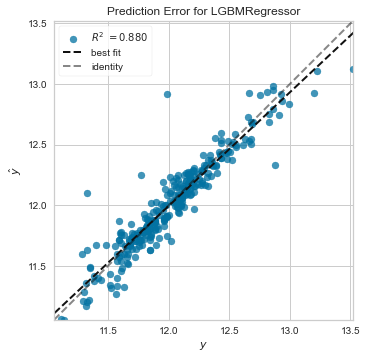

<AxesSubplot:title={'center':'Prediction Error for LGBMRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [155]:
m = pipe.fit(X_train,y_train)
preds = np.exp(m.predict(X_test))
vis = PredictionError(m)
vis.fit(X_train,y_train)
vis.score(X_test,y_test)
vis.show()

In [127]:
m = pipe.fit(X,y)
preds = np.exp(m.predict(test))
test['SalePrice'] = preds
test.set_index("Id")['SalePrice'].to_csv("preds.csv")

<AxesSubplot:>

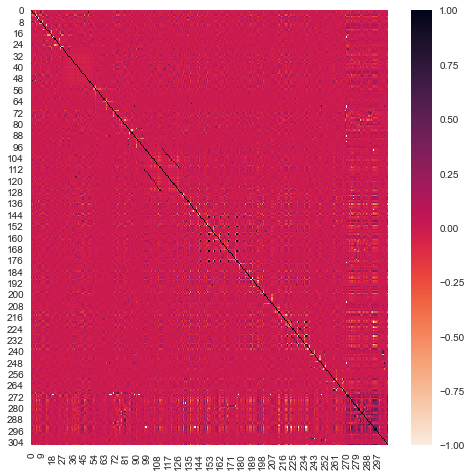

In [170]:
fig,axs=plt.subplots(1,figsize=(8,8))
sns.heatmap(pd.DataFrame(cat_transform.fit_transform(train).todense()).corr(method='pearson'),
            cmap='rocket_r')